<h1>Project Assignment Part - I</h1>
<h5>COMP 6721 Applied Artificial Intelligence</h5>
<ul>
<li>40161500 - Parth Ashokkumar Parekh</li>
<li>40202625 - Santhosh Santhanam</li>
<li>40193868 - Elvin Rejimone</li>
</ul>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import packages

import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from collections import Counter
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn.functional as F
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, precision_recall_fscore_support
from torchvision import models
from torchsummary import summary

In [ ]:
config = {
    'images_folder': 'drive/MyDrive/train',
    'train_batch_size': 64,
    'test_batch_size': 64,
    'valid_batch_size': 64,
    'num_epochs': 20,
    'input_size': 1024,
    'learning_rate': 0.001
}

savedModel = False
model_path = 'drive/MyDrive/model'

In [ ]:
def get_images(images_path, test_split=0.20):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize([32, 32]),
                                    transforms.Normalize((6.4307e-02, -6.7064e-05, -2.5857e-03), (0.9544, 0.9539, 0.9665))])
    dataset = ImageFolder(images_path, transform=transform)

    classLabels = dataset.class_to_idx;
    classImages = dict(Counter(dataset.targets))

    # print(classImages)
    print("\n")

    # Plotting the bar graph of the data
    keys = ["cloth", "n95", "n95 with valve", "surgical", "without mask"]
    values = list(classImages.values())
    plt.bar(keys, values, color ='blue',width = 0.4)
    plt.xlabel("Type of classes")
    plt.ylabel("Number of images")
    plt.title("Number of images in each each mask type")
    plt.show()

    # Showing count of each image
    print("\n")
    for k in keys:
      print(k + ": " + str(classImages[classLabels[k]]))

    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    train = Subset(dataset, train_idx)
    test = Subset(dataset, test_idx)

    return train, test

{0: 608, 1: 375, 2: 501, 3: 525, 4: 510}




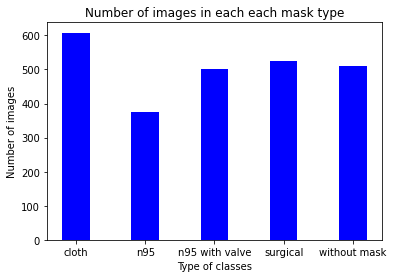



cloth: 608
n95: 375
n95 with valve: 501
surgical: 525
without mask: 510


In [ ]:
train_data, test_data = get_images(config['images_folder'])

In [ ]:
# Getting train and test loader
train_dataloader = DataLoader(train_data, batch_size=config["train_batch_size"], shuffle=True,
                                  pin_memory=False)
test_dataloader = DataLoader(test_data, batch_size=config["test_batch_size"], shuffle=False,
                                 pin_memory=False)

In [ ]:
# CNN model

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(8 * 8 * 64, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 5)
        )

    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x


In [ ]:
# Print the device
device = 'cuda' if torch.cuda.is_available() else "cpu"
print(device)

NameError: ignored

In [ ]:
if savedModel:
  model = Model()
  model.load_state_dict(torch.load(model_path, torch.device('cpu')))
  model.eval()
  model.to(device)
  summary(model, (3, 32, 32))
else:
  model = Model()
  model = model.to(device)
  summary(model, (3, 32, 32))
  optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
  criterion = nn.CrossEntropyLoss()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         LeakyReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         LeakyReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        LeakyReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
      BatchNorm2d-12           [-1, 64, 16, 16]             128
        LeakyReLU-13           [-1, 64, 16, 16]               0
        MaxPool2d-14             [-1, 6

In [ ]:
# Model training class

class ModelTraining:

    def __init__(self, model, device, optimizer, criteria):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criteria = criteria

    def training(self, train_dataloader, epochs):
        total_no_of_steps = len(train_dataloader)
        accuracyList = []
        trainingLoss = []
        for epoch in range(epochs):
            self.model.train()
            train_total = 0
            train_correct = 0
            for i, (images, labels) in enumerate(train_dataloader):
                images = images.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(images)
                loss = self.criteria(outputs, labels)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.shape[0]
                train_correct += (predicted == labels).sum().item()
            print(
                f'Epoch {epoch + 1} / {epochs}, Training loss = {loss.item():.4f}, Training accuracy = {(train_correct / train_total) * 100}')
            accuracyList.append((train_correct / train_total) * 100)
            trainingLoss.append(loss.item())
        return accuracyList, trainingLoss
                # f', Validation loss = {validation_loss.item():.4f}, Validation accuracy = {(correct / total) * 100}')


In [ ]:
# Training the model
if not savedModel:
  model_trainer = ModelTraining(model=model, device=device, optimizer=optimizer, criteria=criterion)
  accuracyList, trainingLossList = model_trainer.training(train_dataloader, epochs=config["num_epochs"])
  torch.save(model.state_dict(), model_path)

Epoch 1 / 20, Training loss = 1.3034, Training accuracy = 41.836228287841195
Epoch 2 / 20, Training loss = 0.9586, Training accuracy = 58.411910669975185
Epoch 3 / 20, Training loss = 0.7415, Training accuracy = 63.374689826302735
Epoch 4 / 20, Training loss = 0.4798, Training accuracy = 66.94789081885855
Epoch 5 / 20, Training loss = 0.9337, Training accuracy = 71.76178660049628
Epoch 6 / 20, Training loss = 0.7834, Training accuracy = 75.68238213399503
Epoch 7 / 20, Training loss = 0.5526, Training accuracy = 78.31265508684864
Epoch 8 / 20, Training loss = 0.7060, Training accuracy = 79.4044665012407
Epoch 9 / 20, Training loss = 0.4636, Training accuracy = 82.23325062034739
Epoch 10 / 20, Training loss = 0.2889, Training accuracy = 86.6501240694789
Epoch 11 / 20, Training loss = 0.4857, Training accuracy = 89.8759305210918
Epoch 12 / 20, Training loss = 0.1600, Training accuracy = 91.16625310173697
Epoch 13 / 20, Training loss = 0.1225, Training accuracy = 94.68982630272953
Epoch 14

Text(0, 0.5, 'Training accuracy')

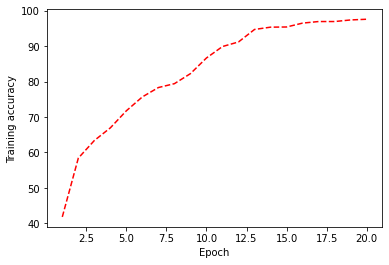

In [ ]:
# Plot the graph of training accuracy vs the epoch
plt.plot(range(1, config['num_epochs']+1), accuracyList, 'r--')
plt.xlabel('Epoch')
plt.ylabel('Training accuracy')

Text(0, 0.5, 'Training Loss')

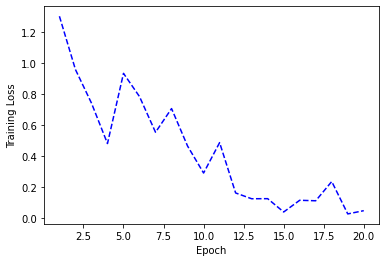

In [ ]:
# Plot the graph of training loss vs the epoch
plt.plot(range(1, config['num_epochs']+1), trainingLossList, 'b--')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

In [ ]:
 # Getting the accuracy of the model
def getModelAccuracy(model, test_dataloader, device):
    model.eval()
    total = 0
    correct = 0
    y_pred = []
    y_true = []
    precision = dict()
    recall = dict()
    avg = dict()
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            model_pred_on_test = model(images)
            model_pred_on_test = torch.argmax(F.softmax(model_pred_on_test.data), 1)
            predicted = model_pred_on_test
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()
            if y_pred == []:
              y_true = labels[:]
              y_pred = model_pred_on_test[:]
            else:
              y_true = torch.hstack([y_true, labels])
              y_pred = torch.hstack([y_pred, model_pred_on_test])
        print('Test Accuracy of the model on the test images: {} %'
              .format((correct / total) * 100))
        y_pred = y_pred.cpu().detach().numpy()
        y_true = y_true.cpu().detach().numpy()
        target_names = ['cm', 'n95', 'n95v', 'sm', 'no mask']
        labels_names = [0, 1, 2, 3, 4]
        print(classification_report(y_true, y_pred, labels=labels_names, target_names=target_names))
        cm = confusion_matrix(y_true, y_pred, labels=labels_names)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
        disp = disp.plot(cmap=plt.cm.Blues, values_format='g')
        plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Test Accuracy of the model on the test images: 69.84126984126983 %
              precision    recall  f1-score   support

          cm       0.72      0.70      0.71       119
         n95       0.71      0.51      0.59        86
        n95v       0.53      0.71      0.61       103
          sm       0.77      0.69      0.73       106
     no mask       0.83      0.88      0.85        90

    accuracy                           0.70       504
   macro avg       0.71      0.70      0.70       504
weighted avg       0.71      0.70      0.70       504



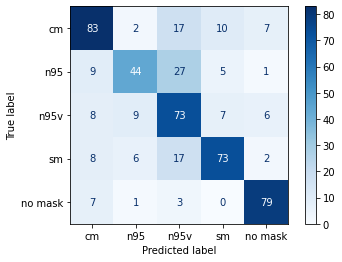

In [ ]:
getModelAccuracy(model, test_dataloader, device)

In [ ]:
 # Predicting single image

def predict_image(model, image, device, labels=['cloth', 'N95', 'N95 with valve', 'Surgical', "without mask"]):

    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image.unsqueeze(0))
    pred = output.argmax(dim=1).cpu().numpy()
    print(pred)
    return labels[pred[0]]

In [ ]:
image = Image.open("drive/MyDrive/train/surgical/SM 525.jpg")
transform = transforms.Compose(
      [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize(mean=(6.4307e-02, -6.7064e-05, -2.5857e-03), std=(0.9544, 0.9539, 0.9665))]
  )
image = transform(image)
print(predict_image(model, image, device))

[3]
Surgical
